# Notebook to adjust radiometry of Planet images using snow-covered pixels and dark areas

Rainey Aberle

Spring 2022

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from scipy.interpolate import interp2d

In [2]:
# -----Determine whether to save output images
save_images = 1 # = 1 to save adjusted raster image files in out_path

# -----Define paths in directory
# path to Planet images
im_path = '/Users/raineyaberle/Research/PhD/Wolverine/imagery/Planet/2021-04-20_2021-08-25/PSScene4Band/'
# output folder
out_path = im_path+'../adjusted-radiometry/'

In [3]:
# -----Load Planet images from directory
ims = os.chdir(im_path) # change directory
im_names = glob.glob('*SR_clip.tif') # load all .tif file names
im_names.sort() # sort file names by date

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


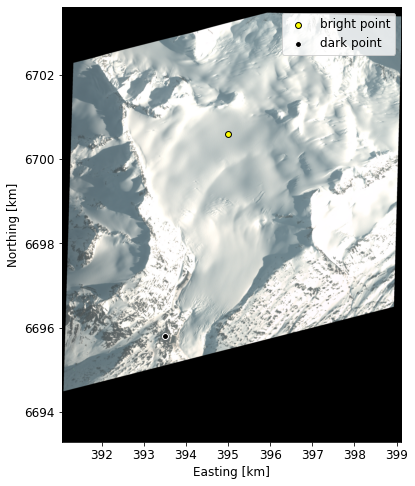

In [4]:
# -----Define 'bright' and 'dark' points used for image radiometric adjustment

bright_pt = [395e3, 6700.6e3]
dark_pt = [393.5e3, 6695.8e3]

# load one image
im = rio.open(im_names[1])
# define bands (blue, green, red, near infrared)
im_scalar = 10000 # scalar multiplier for image reflectance values
b = im.read(1).astype(float) / im_scalar 
g = im.read(2).astype(float) / im_scalar 
r = im.read(3).astype(float) / im_scalar 
nir = im.read(4).astype(float) / im_scalar  
# define coordinates grid
x = np.linspace(im.bounds.left, im.bounds.right, num=np.shape(b)[1])
y = np.linspace(im.bounds.top, im.bounds.bottom, num=np.shape(b)[0])
# plot image with bright and dark points
fig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 12, 'font.serif': 'Arial'})
plt.imshow(np.dstack([r, g, b]), extent=(np.min(x)/1000, np.max(x)/1000, np.min(y)/1000, np.max(y)/1000))
plt.scatter(bright_pt[0]/1000, bright_pt[1]/1000, s=35, facecolor='yellow', edgecolor='black', label='bright point')
plt.scatter(dark_pt[0]/1000, dark_pt[1]/1000, s=35, facecolor='black', edgecolor='white', label='dark point')
plt.xlabel('Easting [km]')
plt.ylabel('Northing [km]')
plt.legend()
plt.show()

In [10]:
# -----Apply radiometric correction by 'stretching' image to brightest and darkest points

# Define desired SR values at the bright and dark points for each band
# bright point
bright_b_adj = 0.94
bright_g_adj = 0.95
bright_r_adj = 0.94
bright_nir_adj = 0.78
# dark point 
dark_b_adj = 0.08
dark_g_adj = 0.09
dark_r_adj = 0.08
dark_nir_adj = 0.10

# Loop through images
y_count = 0
n_count = 0
for im_name in im_names:
    
    # load image
    im = rio.open(im_name)
    
    # define bands (blue, green, red, near infrared)
    im_scalar = 10000 # scalar multiplier for image reflectance values
    b = im.read(1).astype(float) / im_scalar 
    g = im.read(2).astype(float) / im_scalar 
    r = im.read(3).astype(float) / im_scalar 
    nir = im.read(4).astype(float) / im_scalar  
    # replace zero values with nans - NOT WORKING
#     b[b==0] = np.nan
#     g[g==0] = np.nan
#     r[r==0] = np.nan
#     nir[nir==0] = np.nan
    
    # define coordinates grid
    x = np.linspace(im.bounds.left, im.bounds.right, num=np.shape(b)[1])
    y = np.linspace(im.bounds.top, im.bounds.bottom, num=np.shape(b)[0])

    # check if brightest and darkest points exist in image
    if ((bright_pt[0]>np.min(x)) & (bright_pt[0]<np.max(x)) & (bright_pt[1]>np.min(y)) & (bright_pt[1]<np.max(y)) 
        & (dark_pt[0]>np.min(x)) & (dark_pt[0]<np.max(x)) & (dark_pt[1]>np.min(y)) & (dark_pt[1]<np.max(y))):
        

        # check if SR values are greater than zero at bright and dark points
        f_b = interp2d(x, y, b)
        if ( (f_b(bright_pt[0], bright_pt[1])>0) & (~np.isnan(f_b(bright_pt[0], bright_pt[1]))) 
            & (f_b(dark_pt[0], dark_pt[1])>0)& (~np.isnan(f_b(dark_pt[0], dark_pt[1]))) ):
            
            y_count+=1
            print(im_name)

            # adjust SR using bright and dark points
            # band_adjusted = band*A - B
            # A = (bright_adjusted - dark_adjusted) / (bright - dark)
            # B = (dark*bright_adjusted - bright*dark_adjusted) / (bright - dark)
            # blue band
            bright_b = f_b(bright_pt[0], bright_pt[1]) # SR at bright point
            dark_b = f_b(dark_pt[0], dark_pt[1]) # SR at dark point
            A = (bright_b_adj - dark_b_adj) / (bright_b - dark_b)
            B = (dark_b*bright_b_adj - bright_b*dark_b_adj) / (bright_b - dark_b)
            b_adj = (b * A) - B
            # green band
            f_g = interp2d(x, y, g)
            bright_g = f_g(bright_pt[0], bright_pt[1]) # SR at bright point
            dark_g = f_g(dark_pt[0], dark_pt[1]) # SR at dark point
            A = (bright_g_adj - dark_g_adj) / (bright_g - dark_g)
            B = (dark_g*bright_g_adj - bright_g*dark_g_adj) / (bright_g - dark_g)
            g_adj = (g * A) - B
            # red band
            f_r = interp2d(x, y, r)
            bright_r = f_r(bright_pt[0], bright_pt[1]) # SR at bright point
            dark_r = f_r(dark_pt[0], dark_pt[1]) # SR at dark point
            A = (bright_r_adj - dark_r_adj) / (bright_r - dark_r)
            B = (dark_r*bright_r_adj - bright_r*dark_r_adj) / (bright_r - dark_r)
            r_adj = (r * A) - B
            # nir band
            f_nir = interp2d(x, y, nir)
            bright_nir = f_nir(bright_pt[0], bright_pt[1]) # SR at bright point
            dark_nir = f_nir(dark_pt[0], dark_pt[1]) # SR at dark point
            A = (bright_nir_adj - dark_nir_adj) / (bright_nir - dark_nir)
            B = (dark_nir*bright_nir_adj - bright_nir*dark_nir_adj) / (bright_nir - dark_nir)
            nir_adj = (nir * A) - B
            
            # print new values at the bright and dark points to check for success
#             f_b_adj = interp2d(x, y, b_adj)
#             f_g_adj = interp2d(x, y, g_adj)
#             f_r_adj = interp2d(x, y, r_adj)
#             f_nir_adj = interp2d(x, y, nir_adj)
#             print('    blue:',f_b_adj(bright_pt[0], bright_pt[1]),f_b_adj(dark_pt[0],dark_pt[1]))
#             print('    green:',f_g_adj(bright_pt[0], bright_pt[1]),f_g_adj(dark_pt[0],dark_pt[1]))
#             print('    red:',f_r_adj(bright_pt[0], bright_pt[1]),f_r_adj(dark_pt[0],dark_pt[1]))
#             print('    nir:',f_nir_adj(bright_pt[0], bright_pt[1]),f_nir_adj(dark_pt[0],dark_pt[1]))
       
            # plot results
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(16,14),gridspec_kw={'height_ratios': [3,1]})
            plt.rcParams.update({'font.size': 12, 'font.serif': 'Arial'})
            # original image
            im_original = ax1.imshow(np.dstack([r, g, b]), 
                       extent=(np.min(x)/1000, np.max(x)/1000, np.min(y)/1000, np.max(y)/1000))
            ax1.scatter(bright_pt[0]/1000, bright_pt[1]/1000, s=35, facecolor='yellow', 
                        edgecolor='black', label='brightest point')
            ax1.scatter(dark_pt[0]/1000, dark_pt[1]/1000, s=35, facecolor='black', 
                        edgecolor='white', label='darkest point')
            ax1.set_xlabel('Easting [km]')
            ax1.set_ylabel('Northing [km]')
            ax1.set_title('Original image')
            # adjusted image
            im_adjusted = ax2.imshow(np.dstack([r_adj, g_adj, b_adj]), 
                       extent=(np.min(x)/1000, np.max(x)/1000, np.min(y)/1000, np.max(y)/1000))
            ax2.scatter(bright_pt[0]/1000, bright_pt[1]/1000, s=35, facecolor='yellow', 
                        edgecolor='black', label='brightest point')
            ax2.scatter(dark_pt[0]/1000, dark_pt[1]/1000, s=35, facecolor='black', 
                        edgecolor='white', label='darkest point')
            ax2.set_xlabel('Easting [km]')
            ax2.set_title('Adjusted image')
            # histograms
            h1_nir = ax3.hist(nir.flatten(), color='purple', bins=100, alpha=0.5, label='NIR')
            h1_b = ax3.hist(b.flatten(), color='blue', bins=100, alpha=0.5, label='blue')
            h1_g = ax3.hist(g.flatten(), color='green', bins=100, alpha=0.5, label='green')
            h1_r = ax3.hist(r.flatten(), color='red', bins=100, alpha=0.5, label='red')
            ax3.set_xlabel('Surface reflectance')
            ax3.set_ylabel('Pixel counts')
            ax3.grid()
            ax3.legend(loc='right')
            ax3.set_ylim(0,np.max([h1_nir[0][1:], h1_g[0][1:], h1_r[0][1:], h1_b[0][1:]])+5000)
            h2_nir = ax4.hist(nir_adj.flatten(), color='purple', bins=100, alpha=0.5, label='NIR')
            h2_b = ax4.hist(b_adj.flatten(), color='blue', bins=100, alpha=0.5, label='blue')
            h2_g = ax4.hist(g_adj.flatten(), color='green', bins=100, alpha=0.5, label='green')
            h2_r = ax4.hist(r_adj.flatten(), color='red', bins=100, alpha=0.5, label='red')
            ax4.set_xlabel('Surface reflectance')
            ax4.set_ylim(0,np.max([h1_nir[0][1:], h1_g[0][1:], h1_r[0][1:], h1_b[0][1:]])+5000)
            ax4.grid()
            plt.show() 
            
            # save adjusted raster to file
            if save_images==1:
                # file name
                fn = im_name[0:-4]+'_adj.tif'
                # metadata
                out_meta = im.meta.copy()
                out_meta.update({'driver':'GTiff',
                                 'width':b_adj.shape[1],
                                 'height':b_adj.shape[0],
                                 'count':4,
                                 'dtype':'float64',
                                 'crs':im.crs, 
                                 'transform':im.transform})
                # write to file
                with rio.open(out_path+fn, mode='w',**out_meta) as dst:
                    dst.write_band(1,b_adj)
                    dst.write_band(2,g_adj)
                    dst.write_band(3,r_adj)
                    dst.write_band(4,nir_adj)
                print('image saved to file')

        else: 
            n_count+=1
        
    else:
        n_count+=1
    
print('Number of images:',len(im_names))
print('Numer of adjusted images:', y_count)
print('Numer of UN-adjusted images:', n_count)

KeyboardInterrupt: 

In [6]:
# Define image class and list of images
# class image:
#     def __init__(self, im_name, x, y, b, g, r, nir):
#         self.im_name = im_name
#         self.x = x
#         self.y = y
#         self.b = b
#         self.g = g
#         self.r = r
#         self.nir = nir
#     def show(self):
#         print('Image file name:',self.im_name)
# im_list = [] # list for saving image info


    # save image info
#     newImage = image(im_name, x, y, b, g, r, nir)
#     im_list.append(newImage)